# Network Architecture

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import subprocess
import platform

def get_gpu_info():
    print("PyTorch GPU Information:")
    if torch.cuda.is_available():
        print(f"CUDA is available. PyTorch version: {torch.__version__}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        
        for i in range(torch.cuda.device_count()):
            print(f"\nGPU {i}:")
            print(f"  Name: {torch.cuda.get_device_name(i)}")
            print(f"  Compute capability: {torch.cuda.get_device_capability(i)}")
            print(f"  Total memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
            
        # Current device information
        current_device = torch.cuda.current_device()
        print(f"\nCurrent GPU: {current_device}")
        print(f"  Name: {torch.cuda.get_device_name(current_device)}")
        
        # Memory information
        print("\nMemory Usage:")
        print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"  Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    else:
        print("CUDA is not available. Running on CPU.")

    # System GPU information (platform-dependent)
    if platform.system() == "Windows":
        try:
            gpu_info = subprocess.check_output(["nvidia-smi"]).decode('utf-8')
            print("\nNVIDIA-SMI Output:")
            print(gpu_info)
        except:
            print("\nNVIDIA-SMI is not available on this system.")
    elif platform.system() == "Linux":
        try:
            gpu_info = subprocess.check_output(["nvidia-smi"]).decode('utf-8')
            print("\nNVIDIA-SMI Output:")
            print(gpu_info)
        except:
            print("\nNVIDIA-SMI is not available on this system.")
    elif platform.system() == "Darwin":  # macOS
        print("\nOn macOS, detailed GPU information might not be available through nvidia-smi.")
        print("For Apple Silicon (M1/M2) Macs, GPU information is limited.")
    else:
        print("\nUnable to retrieve system GPU information for this platform.")

if __name__ == "__main__":
    get_gpu_info()

PyTorch GPU Information:
CUDA is not available. Running on CPU.

On macOS, detailed GPU information might not be available through nvidia-smi.
For Apple Silicon (M1/M2) Macs, GPU information is limited.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define Generator and Discriminator for time series
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True)
        self.linearh = nn.Linear(hidden_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x)
        x = self.linearh(x)
        x = self.relu(x)
        return self.linear1(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'bias' in name:
                        nn.init.constant_(param, 0.0)
                    elif 'weight' in name:
                        nn.init.xavier_normal_(param)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)
        self.linear_out = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # Only use the last output
        return self.sigmoid(x)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'bias' in name:
                        nn.init.constant_(param, 0.0)
                    elif 'weight' in name:
                        nn.init.xavier_normal_(param)

# Data Preparation

In [3]:
from ngsim_dataset import NGSIMDataset
# settings for data loader
class DataSettings:
    def __init__(self):
        # location of datasets and category
        end_name = 'ngsim_sample.csv' # dataset name
        data_file = end_name # dataset category and dataset name
        # key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels
        
        self.BASE = '/Users/thinhhoang/Documents/TAnoGAN/NGSIM_Dataset'
        # check if self.BASE has the last '/'
        if self.BASE[-1] != '/':
            self.BASE += '/'
        # self.label_file = 'labels\\combined_windows.json'
        self.data_file = data_file
        # self.key = key
        self.train = True
        self.window_length = 60
        self.column_name = 'Velocity'

dataset = NGSIMDataset(data_settings = DataSettings())
print(f'Shape of dataset: {dataset.x.shape}')

Select column name: Velocity
Shape of dataset: torch.Size([1800, 60, 1])


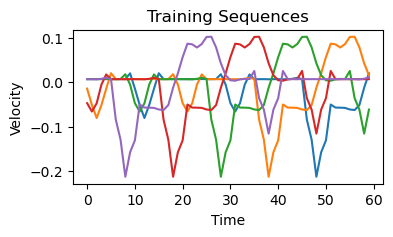

In [4]:
import matplotlib.pyplot as plt
def plot_series(ngsim_dataset, n=5):
    plt.figure(figsize=(4, 2))
    for i in range(n):
        plt.plot(ngsim_dataset.x[i])
    plt.title('Training Sequences')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.show()

plot_series(dataset, n=5)

# Hyperparameters

In [5]:
# Hyperparameters
seq_len = 60
input_dim = 32
hidden_dim = 128
batch_size = 16
num_epochs = 20_000

def model_initialization():
    # Initialize models and optimizers
    generator = Generator(input_dim, hidden_dim, seq_len)
    discriminator = Discriminator(input_dim, hidden_dim, seq_len)
    g_optimizer = optim.Adam(generator.parameters(), lr=0.00005)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005)

    # Summary of the models
    print("=====Generator=====")
    print(generator)
    print("=====Discriminator=====")
    print(discriminator)
    # print("=====Generator Optimizer=====")
    # print(g_optimizer)
    # print("=====Discriminator Optimizer=====")
    # print(d_optimizer)

    # Loss function
    criterion = nn.BCELoss()
    print('Model initialization OK')
    return generator, discriminator, g_optimizer, d_optimizer, criterion

# Training loop

In [41]:
# Initialize models and optimizers
generator, discriminator, g_optimizer, d_optimizer, criterion = model_initialization()

=====Generator=====
Generator(
  (lstm): LSTM(32, 128, num_layers=3, batch_first=True)
  (linearh): Linear(in_features=128, out_features=128, bias=True)
  (linear1): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)
=====Discriminator=====
Discriminator(
  (lstm): LSTM(32, 128, num_layers=4, batch_first=True)
  (linear_out): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Model initialization OK


In [42]:
# Delete all files in qualitycheck folder
import os
import shutil
folder = 'qualitycheck'

# If folder does not exist, create it
if not os.path.exists(folder):
    os.makedirs(folder)

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

## **Pretraining the generator** ??

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the generator to the GPU
generator = generator.to(device)

g_losses = []
num_epochs = 500
batch_size = 32
pretrain_crit = nn.MSELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.003)

for epoch in range(num_epochs):
    # Generate real data
    # real_data = torch.tensor(np.random.choice(dataset.x, batch_size), dtype=torch.float32).to(device)
    real_data = torch.tensor(np.repeat(dataset.x[0].reshape(1, 60, 1), batch_size, axis=0), dtype=torch.float32).to(device)
    
    g_optimizer.zero_grad()
    
    # Fake data
    z = torch.randn(batch_size, seq_len, input_dim, device=device)
    fake_data = generator(z)
    
    # Update the generator
    g_loss = pretrain_crit(fake_data, real_data)
    g_loss.backward()
    g_optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], g_loss: {g_loss.item():.4f}')
        g_losses.append(g_loss.item())

/var/folders/lm/mmss816142xg1l8dk_cq_j_h0000gn/T/ipykernel_5710/1321435479.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(np.repeat(dataset.x[0].reshape(1, 60, 1), batch_size, axis=0), dtype=torch.float32)


Epoch [10/500], g_loss: 0.0019
Epoch [20/500], g_loss: 0.0017
Epoch [30/500], g_loss: 0.0016
Epoch [40/500], g_loss: 0.0014
Epoch [50/500], g_loss: 0.0012
Epoch [60/500], g_loss: 0.0013
Epoch [70/500], g_loss: 0.0013
Epoch [80/500], g_loss: 0.0010
Epoch [90/500], g_loss: 0.0010
Epoch [100/500], g_loss: 0.0010
Epoch [110/500], g_loss: 0.0014
Epoch [120/500], g_loss: 0.0009
Epoch [130/500], g_loss: 0.0009
Epoch [140/500], g_loss: 0.0009
Epoch [150/500], g_loss: 0.0010
Epoch [160/500], g_loss: 0.0009
Epoch [170/500], g_loss: 0.0008
Epoch [180/500], g_loss: 0.0008
Epoch [190/500], g_loss: 0.0008
Epoch [200/500], g_loss: 0.0011
Epoch [210/500], g_loss: 0.0018
Epoch [220/500], g_loss: 0.0011
Epoch [230/500], g_loss: 0.0009
Epoch [240/500], g_loss: 0.0008
Epoch [250/500], g_loss: 0.0008
Epoch [260/500], g_loss: 0.0005
Epoch [270/500], g_loss: 0.0012
Epoch [280/500], g_loss: 0.0003
Epoch [290/500], g_loss: 0.0003
Epoch [300/500], g_loss: 0.0002
Epoch [310/500], g_loss: 0.0006
Epoch [320/500], 

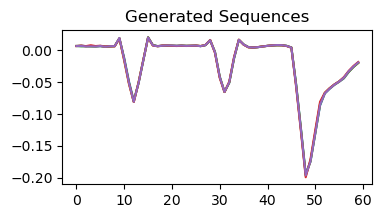

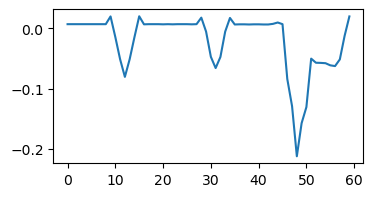

In [47]:
# Generate some examples from the generator
z = torch.randn(5, seq_len, input_dim)
fake_data = generator(z).detach().numpy()

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(fake_data[i])
plt.title('Generated Sequences')

plt.figure(figsize=(4, 2))
plt.plot(dataset.x[0])

## **Main training loop**

In [ ]:
# Training loop
d_losses = []
g_losses = []
num_epochs = 1000
for epoch in range(num_epochs):
    # Generate real data
    real_data = torch.tensor(dataset.x[np.random.choice(len(dataset), batch_size)], dtype=torch.float32)

    # Train Discriminator
    d_optimizer.zero_grad()
    
    # Real data
    real_labels = torch.ones(batch_size, 1)
    outputs = discriminator(real_data)
    d_loss_real = criterion(outputs, real_labels)
    
    # Fake data
    z = torch.randn(batch_size, seq_len, input_dim)
    fake_data = generator(z)
    fake_labels = torch.zeros(batch_size, 1)
    outputs = discriminator(fake_data.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    # d_optimizer.step()

    # Train Generator
    g_optimizer.zero_grad()
    z = torch.randn(batch_size, seq_len, input_dim)
    fake_data = generator(z)
    outputs = discriminator(fake_data)
    g_loss = criterion(outputs, real_labels)
    g_loss.backward()
    # g_optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        # Sample the generator to check the quality of the generated samples
        z = torch.randn(1, seq_len, input_dim)
        fake_data = generator(z).detach().numpy().reshape(seq_len)
        plt.figure(figsize=(4, 2))
        plt.plot(fake_data)
        plt.title('Generated Sequence')
        plt.xlabel('Time')
        plt.ylabel('Velocity')
        plt.savefig(f'qualitycheck/seq_{epoch+1}.png')

    if (epoch + 1) % 5000 == 0:
        
        user_input = input("Do you want to continue training? (yes/no): ")
        if user_input.lower() == "no":
            break


In [ ]:
from matplotlib import pyplot as plt 
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.legend()
plt.show()

In [ ]:
for i in range(10):
    plt.plot(dataset.x[np.random.choice(len(dataset), batch_size)][i,:,0])

In [ ]:
for i in range(10):
    z = torch.randn(1, seq_len, input_dim)
    fake_data = generator(z).detach().numpy().reshape(seq_len)
    plt.plot(fake_data)